In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import pickle as pkl
from itertools import product
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm import tqdm
from matplotlib import pyplot as plt
from datetime import timedelta, datetime
from joblib import delayed, Parallel
from copy import copy

from core import  do_simulation
from helpers import Params, T, get_T1_and_T2, R0, plot_total, DATE_FORMAT, total_to_csv, save_to_json, save_bundle

from const import STATE, COLORS, NUM_STATES,  STATES


In [3]:
p0_time = pkl.load(open('output/p0_time.pkl', 'rb'))
lockdown_time = T('23/01/2020')

In [4]:
params_before = pkl.load(
    open('output/params_before_lockdown.pkl', 'rb')
)

params_after = pkl.load(
    open('output/params_after_lockdown.pkl', 'rb')
)
bed_info = pkl.load(open('data/bed_info.pkl', 'rb'))

In [5]:
total_days =  360

In [6]:
def one_run(delta_t, total_days=360):
    delta = timedelta(days=delta_t)
    assumed_ld_date = lockdown_time + delta
    days_to_p0 = (assumed_ld_date - p0_time).days
    print('lockdown date',  assumed_ld_date)
    params = Params(
        total_population=params_before.total_population,
        initial_num_E=params_before.initial_num_E,
        initial_num_I=params_before.initial_num_I,
        initial_num_M=params_before.initial_num_M,    
        alpha=[(0, params_before.alpha), (days_to_p0, params_after.alpha)],
        beta=[(0, params_before.beta), (days_to_p0, params_after.beta)],
        stages=[days_to_p0]
    )
    
    total, delta, increase, trans, stats = do_simulation(total_days, bed_info, params, p0_time=p0_time)
    bundle = [total, delta, increase, trans]
    return assumed_ld_date, delta_t, bundle, stats

In [7]:
rows = Parallel(n_jobs=-1)(delayed(one_run)(delta_t, total_days) for  delta_t in range(-7, 8))

-7
2020-01-16
['29/11/19' '09/02/20' '21/04/20' '02/07/20' '12/09/20' '23/11/20']


/home/cloud-user/code/covid-19/helpers.py:285: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf['index'] = df.index
/home/cloud-user/code/covid-19/helpers.py:286: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf['value'] = subdf[state].copy()
/home/cloud-user/code/covid-19/helpers.py:288: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas

-6
2020-01-17
['29/11/19' '09/02/20' '21/04/20' '02/07/20' '12/09/20' '23/11/20']
-5
2020-01-18
['29/11/19' '09/02/20' '21/04/20' '02/07/20' '12/09/20' '23/11/20']
-4
2020-01-19
['29/11/19' '09/02/20' '21/04/20' '02/07/20' '12/09/20' '23/11/20']
-3
2020-01-20
['29/11/19' '09/02/20' '21/04/20' '02/07/20' '12/09/20' '23/11/20']
-2
2020-01-21
['29/11/19' '09/02/20' '21/04/20' '02/07/20' '12/09/20' '23/11/20']
-1
2020-01-22
['29/11/19' '09/02/20' '21/04/20' '02/07/20' '12/09/20' '23/11/20']
0
2020-01-23
['29/11/19' '09/02/20' '21/04/20' '02/07/20' '12/09/20' '23/11/20']
1
2020-01-24
['29/11/19' '09/02/20' '21/04/20' '02/07/20' '12/09/20' '23/11/20']
2
2020-01-25
['29/11/19' '09/02/20' '21/04/20' '02/07/20' '12/09/20' '23/11/20']
3
2020-01-26
['29/11/19' '09/02/20' '21/04/20' '02/07/20' '12/09/20' '23/11/20']
4
2020-01-27
['29/11/19' '09/02/20' '21/04/20' '02/07/20' '12/09/20' '23/11/20']
5
2020-01-28
['29/11/19' '09/02/20' '21/04/20' '02/07/20' '12/09/20' '23/11/20']
6
2020-01-29
['29/11/1

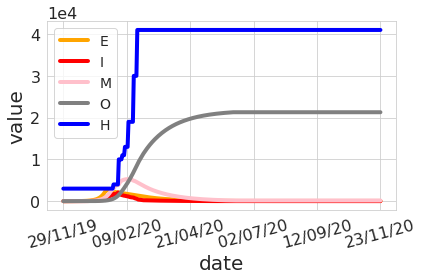

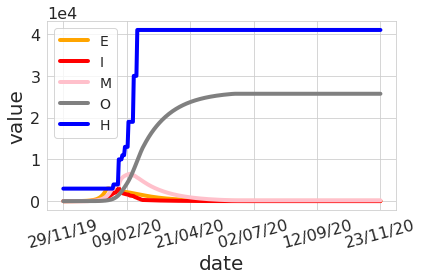

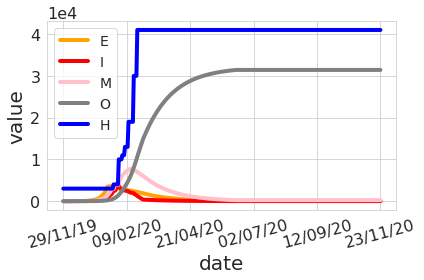

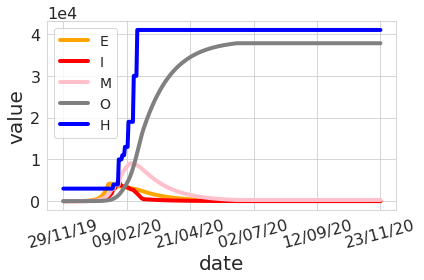

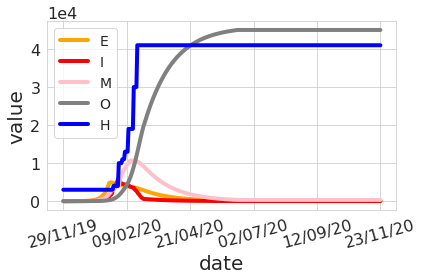

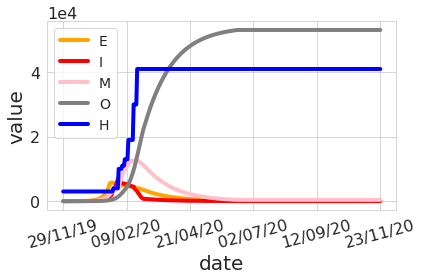

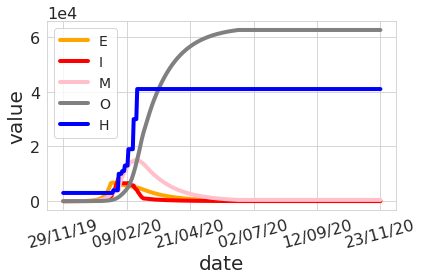

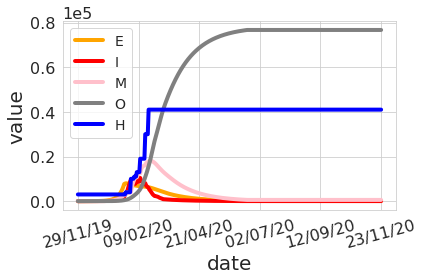

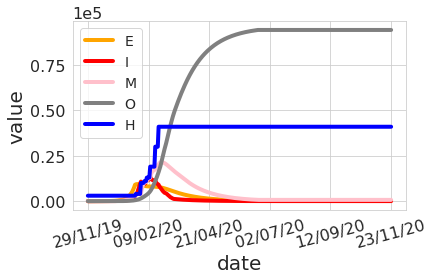

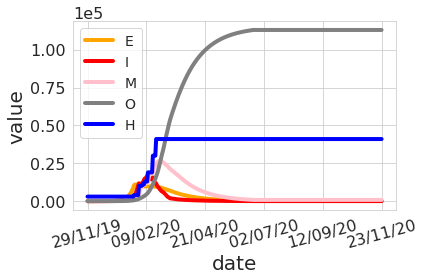

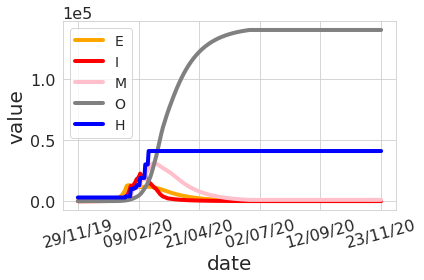

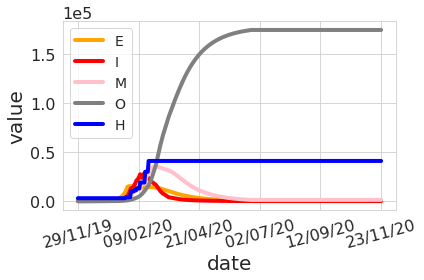

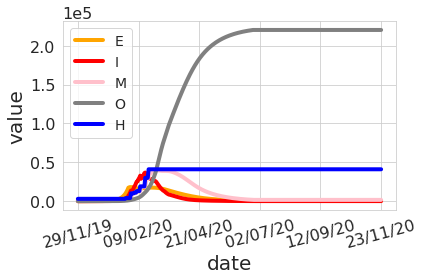

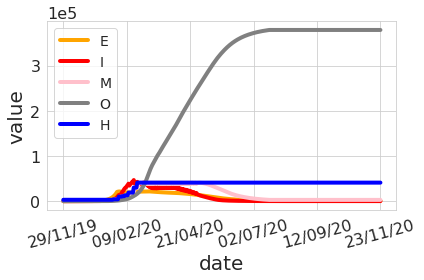

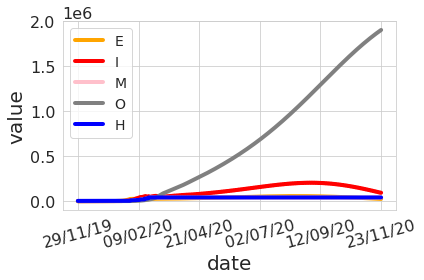

In [8]:
for dt, days, bundle, stats in rows:
    dt_str = dt.strftime('%Y-%m-%d')
    print(days)
    print(dt_str)
    fig, ax = plot_total(bundle[0], p0_time, total_days)
    fig.savefig(f'figs/advance-or-delay-lockdown/{dt_str}({days}).pdf')

    save_bundle(bundle, p0_time, total_days, f'output/tbl/advance-or-delay-lockdown/{dt_str}-({days})/')
    save_to_json(stats, f'output/tbl/advance-or-delay-lockdown/{dt_str}-({days})/stats.txt')

## below not useful

In [48]:
bed_info_raw = pkl.load(open('data/bed_info_raw.pkl', 'rb'))

In [49]:
def one_run_for_R0(delta_t, days_after_ld=30):
    delta = timedelta(days=delta_t)
    assumed_ld_date = lockdown_time + delta
    days_to_p0 = (assumed_ld_date - p0_time).days
    print('lockdown date',  assumed_ld_date)

    bed_info_before_ld = [((d-p0_time).days, n) for d, n in bed_info_raw if d <= assumed_ld_date ]
    params = Params(
        initial_num_I=params_before.initial_num_I, 
        initial_num_E=params_before.initial_num_E,
        initial_num_M=params_before.initial_num_M,
        alpha=[(0, params_before.alpha), (days_to_p0, params_after.alpha)],
        beta=[(0, params_before.beta), (days_to_p0, params_after.beta)],
        stages=[days_to_p0]
    )
    _, _, _, stats = do_simulation(days_to_p0+days_after_ld, bed_info_before_ld, params, p0_time=p0_time)

    return delta_t, assumed_ld_date, stats

In [50]:
days_after_ld = 30
rows2 = Parallel(n_jobs=-1)(delayed(one_run_for_R0)(delta_t, days_after_ld) for  delta_t in  range(-7, 8))

In [51]:
new_rows = []
for delta_t, assumed_ld_date, stats in rows2:
    dt_str = assumed_ld_date.strftime('%Y-%m-%d')
    r0_info = stats['R0_by_stage']
    row = (assumed_ld_date, delta_t) + r0_info[0] + r0_info[1]
    new_rows.append(row)
df = pd.DataFrame(new_rows, columns=['ld_date', 'days_offset',
                                'T1(before)', 'T2(before)', 'R0(before)',
                                'T1(after)', 'T2(after)', 'R0(after)'])
df.to_csv('output/tbl/advance-or-delay-lockdown/R0-before-and-after-lockdown.csv', index=None)

In [52]:
df

,ld_date,days_offset,T1(before),T2(before),R0(before),T1(after),T2(after),R0(after)
0,2020-01-16,-7,5.140316,2.343177,2.647695,5.936336,4.409978,1.972621
1,2020-01-17,-6,5.140354,2.347231,2.647996,5.921912,4.680058,1.977618
2,2020-01-18,-5,5.140381,2.351952,2.648341,5.909275,5.055756,1.985689
3,2020-01-19,-4,5.140399,2.357453,2.648740,5.898249,5.544623,1.997005
4,2020-01-20,-3,5.140407,2.363861,2.649200,5.888714,6.357212,2.017146
5,2020-01-21,-2,5.140406,2.371323,2.649733,5.880523,7.598662,2.048873
6,2020-01-22,-1,5.140396,2.380007,2.650350,5.873536,9.302928,2.093055
7,2020-01-23,0,5.140377,2.390100,2.651065,5.867622,11.375485,2.147151
8,2020-01-24,1,5.140348,2.401813,2.651893,5.862674,13.275313,2.196776
9,2020-01-25,2,5.140309,2.407228,2.652267,5.866814,11.506105,2.150486
